In [1]:
import numpy as np
import os
data_dir = "../_data"
os.makedirs(data_dir, exist_ok=True)


In [2]:
data_sources = {
    "training_images": "train-images-idx3-ubyte.gz",  # 60,000 training images.
    "test_images": "t10k-images-idx3-ubyte.gz",  # 10,000 test images.
    "training_labels": "train-labels-idx1-ubyte.gz",  # 60,000 training labels.
    "test_labels": "t10k-labels-idx1-ubyte.gz",  # 10,000 test labels.
}

In [3]:
import gzip

mnist_dataset = {}

# Images
for key in ("training_images", "test_images"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(
            mnist_file.read(), np.uint8, offset=16
        ).reshape(-1, 28 * 28)
# Labels
for key in ("training_labels", "test_labels"):
    with gzip.open(os.path.join(data_dir, data_sources[key]), "rb") as mnist_file:
        mnist_dataset[key] = np.frombuffer(mnist_file.read(), np.uint8, offset=8)

In [4]:
mnist_dataset

{'training_images': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'test_images': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'training_labels': array([5, 0, 4, ..., 5, 6, 8], dtype=uint8),
 'test_labels': array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)}

In [5]:
x_train, y_train, x_test, y_test = (
    mnist_dataset["training_images"],
    mnist_dataset["training_labels"],
    mnist_dataset["test_images"],
    mnist_dataset["test_labels"],
)

In [6]:
print(
    "The shape of training images: {} and training labels: {}".format(
        x_train.shape, y_train.shape
    )
)
print(
    "The shape of test images: {} and test labels: {}".format(
        x_test.shape, y_test.shape
    )
)

The shape of training images: (60000, 784) and training labels: (60000,)
The shape of test images: (10000, 784) and test labels: (10000,)


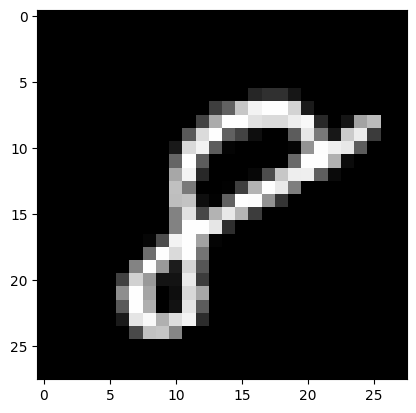

In [7]:
import matplotlib.pyplot as plt

# Take the 60,000th image (indexed at 59,999) from the training set,
# reshape from (784, ) to (28, 28) to have a valid shape for displaying purposes.
mnist_image = x_train[59999, :].reshape(28, 28)
# Set the color mapping to grayscale to have a black background.
plt.imshow(mnist_image, cmap="gray")
# Display the image.
plt.show()

The images data contain 8-bit integers encoded in the [0, 255] interval with color values between 0 and 255.

You will normalize them into floating-point arrays in the [0, 1] interval by dividing them by 255.

In [8]:
training_sample, test_sample = 1000, 1000
training_images = x_train[0:training_sample] / 255
test_images = x_test[0:test_sample] / 255

In [9]:
print("The data type of training labels: {}".format(y_train.dtype))
print("The data type of test labels: {}".format(y_test.dtype))

The data type of training labels: uint8
The data type of test labels: uint8


In [10]:
def one_hot_encoding(labels, dimension=10):
    # Define a one-hot variable for an all-zero vector
    # with 10 dimensions (number labels from 0 to 9).
    one_hot_labels = labels[..., None] == np.arange(dimension)[None]
    # Return one-hot encoded labels.
    return one_hot_labels.astype(np.float64)

In [11]:
training_labels = one_hot_encoding(y_train[:training_sample])
test_labels = one_hot_encoding(y_test[:test_sample])

In [12]:
print("The data type of training labels: {}".format(training_labels.dtype))
print("The data type of test labels: {}".format(test_labels.dtype))

The data type of training labels: float64
The data type of test labels: float64


In [13]:
training_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [14]:
training_labels[0].argmax(axis=0)

5

In [15]:
print(y_train[0])

5


Our shallow nnet has 2 layers which includes a relu and dropout.

In [16]:
seed = 884736743
rng = np.random.default_rng(seed)

In [17]:
# Define ReLU that returns the input if it's positive and 0 otherwise.
def relu(x):
    return (x >= 0) * x


# Set up a derivative of the ReLU function that returns 1 for a positive input
# and 0 otherwise.
def relu2deriv(output):
    return output >= 0

In [18]:
def mse_loss(y, pred, reduction="sum"):
     l = (y - pred) ** 2
     if reduction == "sum":
        return np.sum(l)
     if reduction == "mean":
        return np.mean(l)

In [19]:
def softmax(X):
    exps = np.exp(X)
    return exps / np.sum(exps)

In [20]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [21]:
learning_rate = 0.005
epochs = 20
hidden_size = 100
pixels_per_image = 784
num_labels = 10

In [25]:
weights_1 = 0.2 * rng.random((pixels_per_image, hidden_size)) - 0.1
weights_2 = 0.2 * rng.random((hidden_size, num_labels)) - 0.1

In [26]:
# To store training and test set losses and accurate predictions
# for visualization.
store_training_loss = []
store_training_accurate_pred = []
store_test_loss = []
store_test_accurate_pred = []

# This is a training loop.
# Run the learning experiment for a defined number of epochs (iterations).
for j in range(epochs):

    #################
    # Training step #
    #################

    # Set the initial loss/error and the number of accurate predictions to zero.
    training_loss = 0.0
    training_accurate_predictions = 0

    # For all images in the training set, perform a forward pass
    # and backpropagation and adjust the weights accordingly.
    for i in range(len(training_images)):
        layer_0 = training_images[i]
        # Forward propagation/forward pass:
        # 1. The hidden layer:
        #    Take in the training image data into the middle layer by
        #    matrix-multiplying it by randomly initialized weights.
        layer_1 = np.dot(training_images[i], weights_1)
        # 2. Pass the hidden layer's output through the ReLU activation function.
        layer_1 = relu(layer_1)
        # 3. Define the dropout function for regularization.
        dropout_mask = rng.integers(low=0, high=2, size=layer_1.shape)
        # 4. Apply dropout to the hidden layer's output.
        layer_1 *= dropout_mask * 2
        # 5. The output layer:
        #    Ingest the output of the middle layer into the the final layer
        #    by matrix-multiplying it by randomly initialized weights.
        #    Produce a 10-dimension vector with 10 scores.
        layer_2 = np.dot(layer_1, weights_2)
        #layer_2 = softmax(layer_2)

        
        # Backpropagation/backward pass:
        # 1. Measure the training error (loss function) between the actual
        #    image labels (the truth) and the prediction by the model.
        training_loss += mse_loss(training_labels[i],layer_2, reduction="mean")
        #training_loss += cross_entropy(layer_2, training_labels[i])
        # 2. Increment the accurate prediction count.
        training_accurate_predictions += int(
            np.argmax(layer_2) == np.argmax(training_labels[i])
        )
            
        # 3. Differentiate the loss function/error.
        layer_2_delta =  (training_labels[i] - layer_2)
        # 4. Propagate the gradients of the loss function back through the hidden layer.
        layer_1_delta = np.dot(weights_2, layer_2_delta) * relu2deriv(layer_1)
        # 5. Apply the dropout to the gradients.
        layer_1_delta *= dropout_mask
        # 6. Update the weights for the middle and input layers
        #    by multiplying them by the learning rate and the gradients.
        weights_1 += learning_rate * np.outer(layer_0, layer_1_delta)
        weights_2 += learning_rate * np.outer(layer_1, layer_2_delta)

    # Store training set losses and accurate predictions.
    store_training_loss.append(training_loss)
    store_training_accurate_pred.append(training_accurate_predictions)

    ###################
    # Evaluation step #
    ###################

    # Evaluate model performance on the test set at each epoch.

    # Unlike the training step, the weights are not modified for each image
    # (or batch). Therefore the model can be applied to the test images in a
    # vectorized manner, eliminating the need to loop over each image
    # individually:

    results = relu(test_images @ weights_1) @ weights_2

    # Measure the error between the actual label (truth) and prediction values.
    test_loss = np.sum((test_labels - results) ** 2)

    # Measure prediction accuracy on test set
    test_accurate_predictions = np.sum(
        np.argmax(results, axis=1) == np.argmax(test_labels, axis=1)
    )

    # Store test set losses and accurate predictions.
    store_test_loss.append(test_loss)
    store_test_accurate_pred.append(test_accurate_predictions)

    # Summarize error and accuracy metrics at each epoch
    print(
        "\n"
        + "Epoch: "
        + str(j)
        + " Training set error:"
        + str(training_loss / float(len(training_images)))[0:5]
        + " Training set accuracy:"
        + str(training_accurate_predictions / float(len(training_images)))
        + " Test set error:"
        + str(test_loss / float(len(test_images)))[0:5]
        + " Test set accuracy:"
        + str(test_accurate_predictions / float(len(test_images)))
    )



Epoch: 0 Training set error:0.090 Training set accuracy:0.392 Test set error:0.660 Test set accuracy:0.633

Epoch: 1 Training set error:0.065 Training set accuracy:0.617 Test set error:0.600 Test set accuracy:0.658

Epoch: 2 Training set error:0.059 Training set accuracy:0.692 Test set error:0.564 Test set accuracy:0.684

Epoch: 3 Training set error:0.056 Training set accuracy:0.693 Test set error:0.531 Test set accuracy:0.722

Epoch: 4 Training set error:0.054 Training set accuracy:0.733 Test set error:0.511 Test set accuracy:0.732

Epoch: 5 Training set error:0.051 Training set accuracy:0.739 Test set error:0.495 Test set accuracy:0.742

Epoch: 6 Training set error:0.049 Training set accuracy:0.754 Test set error:0.476 Test set accuracy:0.75

Epoch: 7 Training set error:0.049 Training set accuracy:0.741 Test set error:0.473 Test set accuracy:0.756

Epoch: 8 Training set error:0.047 Training set accuracy:0.772 Test set error:0.473 Test set accuracy:0.768

Epoch: 9 Training set error:

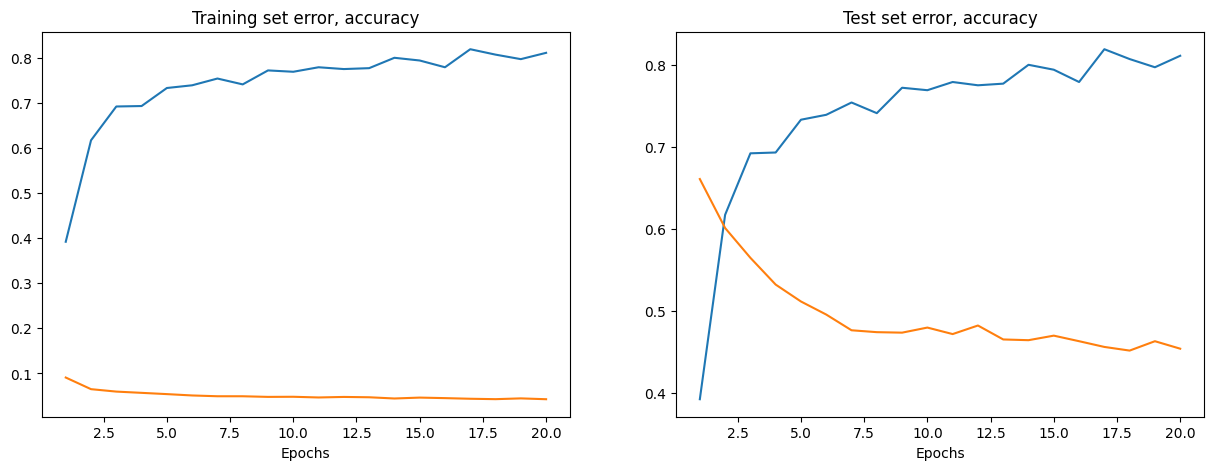

In [27]:
# The training set metrics.
y_training_error = [
    store_training_loss[i] / float(len(training_images))
    for i in range(len(store_training_loss))
]
x_training_error = range(1, len(store_training_loss) + 1)
y_training_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_training_accuracy = range(1, len(store_training_accurate_pred) + 1)

# The test set metrics.
y_test_error = [
    store_test_loss[i] / float(len(test_images)) for i in range(len(store_test_loss))
]
x_test_error = range(1, len(store_test_loss) + 1)
y_test_accuracy = [
    store_training_accurate_pred[i] / float(len(training_images))
    for i in range(len(store_training_accurate_pred))
]
x_test_accuracy = range(1, len(store_test_accurate_pred) + 1)

# Display the plots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title("Training set error, accuracy")
axes[0].plot(x_training_accuracy, y_training_accuracy, label="Training set accuracy")
axes[0].plot(x_training_error, y_training_error, label="Training set error")
axes[0].set_xlabel("Epochs")
axes[1].set_title("Test set error, accuracy")
axes[1].plot(x_test_accuracy, y_test_accuracy, label="Test set accuracy")
axes[1].plot(x_test_error, y_test_error, label="Test set error")
axes[1].set_xlabel("Epochs")
plt.show()